## Telco Customer Churn - Modeling 

### Import required packages and load dataset

In [20]:
# general packages
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pickle

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix,classification_report

# imbelearn package
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', sep = ',')

# print first few rows of df 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Convert Total Charges variable to float for numeric analysis and impute median value for records converted to NA after float conversion

In [4]:
# convert the data type of TotalCharges from 'object' to 'float'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)

### Convert Tenure with the company into categories for new, middle, long-term customers. Break monthly charges into categories for low, medium, high monthly charges. Break total charges into categories for low, high total charges

In [5]:
# Convert Tenure with the company into categories for new, middle, long-term customers 
df.loc[df['tenure']<=15, 'tenureCat'] = "New Customers"
df.loc[df['tenure'].between(16,50), 'tenureCat'] = "Middle Customers"
df.loc[df['tenure']>=51, 'tenureCat'] = "Long-Time Customers"

# Break monthly charges into categories for low, medium, high monthly charges 
df.loc[df['MonthlyCharges']<=35, 'MCC'] = "0-35"
df.loc[df['MonthlyCharges'].between(36,65), 'MCC'] = "36-65"
df.loc[df['MonthlyCharges']>=66, 'MCC'] = ">66"

# Break total charges into categories for low, high total charges 
df.loc[df['TotalCharges']<=2000, 'TCC'] = "0-2000"
df.loc[df['TotalCharges']>=2001, 'TCC'] = ">2000"

### Convert categorical variables into numeric categories

In [6]:
df['gender'] =df['gender'].astype('category').cat.codes
df['tenure'] =df['tenure'].astype('category').cat.codes
df['SeniorCitizen'] =df['SeniorCitizen'].astype('category').cat.codes
df['Partner'] =df['Partner'].astype('category').cat.codes
df['Dependents'] =df['Dependents'].astype('category').cat.codes
df['PhoneService'] =df['PhoneService'].astype('category').cat.codes
df['MultipleLines'] =df['MultipleLines'].astype('category').cat.codes
df['InternetService'] =df['InternetService'].astype('category').cat.codes
df['OnlineSecurity'] =df['OnlineSecurity'].astype('category').cat.codes
df['OnlineBackup'] =df['OnlineBackup'].astype('category').cat.codes
df['DeviceProtection'] =df['DeviceProtection'].astype('category').cat.codes
df['TechSupport'] =df['TechSupport'].astype('category').cat.codes
df['StreamingTV'] =df['StreamingTV'].astype('category').cat.codes
df['StreamingMovies'] =df['StreamingMovies'].astype('category').cat.codes
df['Contract'] =df['Contract'].astype('category').cat.codes
df['PaperlessBilling'] =df['PaperlessBilling'].astype('category').cat.codes
df['PaymentMethod'] =df['PaymentMethod'].astype('category').cat.codes
df['Churn'] =df['Churn'].astype('category').cat.codes
# User created categorical variabels 
df['tenureCat'] =df['tenureCat'].astype('category').cat.codes
df['TCC'] =df['TCC'].astype('category').cat.codes
df['MCC'] =df['MCC'].astype('category').cat.codes

### Drop customerID, as we will not need it for modeling 

In [7]:
df = df.drop('customerID', 1)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenureCat,MCC,TCC
0,0,0,1,0,1,0,1,0,0,2,...,0,0,1,2,29.85,29.85,0,2,0,0
1,1,0,0,0,34,1,0,0,2,0,...,0,1,0,3,56.95,1889.50,0,1,1,0
2,1,0,0,0,2,1,0,0,2,2,...,0,0,1,3,53.85,108.15,1,2,1,0
3,1,0,0,0,45,0,1,0,2,0,...,0,1,0,0,42.30,1840.75,0,1,1,0
4,0,0,0,0,2,1,0,1,0,0,...,0,0,1,2,70.70,151.65,1,2,2,0


### We identified highly correlated features to see if removal of them improved scoring, but it did not so all variables were kept

In [8]:
# # Create correlation matrix
# corr_matrix = df.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find features with correlation greater than 0.90
# to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# to_drop

# # Drop features 
# df.drop(to_drop, axis=1, inplace=True)

### Split Dataset into test/train. We will test accuracy outputs with a standardized dataset and a dataset using polynomial varibles to determine what yields the best output

In [17]:
# split features from outcomes for model prep
x_unscaled = df.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22]]
y = df.iloc[:, 19]

# Add polynomial features to x 
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x_unscaled)

# split the data for modeling
x_train, x_test, y_train, y_test = train_test_split(x_unscaled, y, test_size=0.2, random_state = 42)

# split the data using polynomial features for x and log value for y
x_trainPoly, x_testPoly, y_trainPoly, y_testPoly = train_test_split(x_poly, y, test_size=0.2, random_state = 42)

### Conduct standard scaling on the dataset. For the training dataset we will fit and normalize. For the test dataset we will just trasnform the variables, using the same params that it learned from the training data

In [11]:
# Conduct Standard Scaling 
scaler = StandardScaler()
x_train = scaler.fit_transform( x_train )
x_test = scaler.transform( x_test )

### SMOTE was tested to see if it would increase scoring metrics due to the imbalanced dataset. Negative MSE increases, but F-1 scoring and accuracy improved slightly without SMOTE

In [11]:
# sm = SMOTE()
# x_train, y_train = sm.fit_resample(x_train, y_train)

# # check shape of x_train and y_train, and new response variable ratio
# print(x_train.shape)
# print(y_train.shape)
# print(y_train.value_counts(normalize = True))

### We will run our training dataset through a number of different binary classification models, using negative mean squared error as a measuring stick to determine which models may provide optimized outputs. 

### As we can see, models employing ensemble learning perform better than standard binary classification models 

### Polynomial features vs. scaled features seem to yield fairly similar negative MSE results, with the standardized features performing *slightly* better 

In [22]:
pipelines = []
# Standard binary classification models 
pipelines.append(('LogisticRegression', Pipeline([('LR',linear_model.LogisticRegression(max_iter=1000))])))
pipelines.append(('KNearestNeighbors', Pipeline([('KNN',KNeighborsClassifier(algorithm = 'brute', n_jobs=-1))])))
pipelines.append(('LinearSVC', Pipeline([('SVC',LinearSVC(C=0.0001))])))
pipelines.append(('DecisionTree', Pipeline([('DTREE',DecisionTreeClassifier())])))
# Employment of ensemble learning 
pipelines.append(('BaggingClassifier', Pipeline([('BAG',BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10))])))
pipelines.append(('BoostClassifier', Pipeline([('BOOST',AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6))])))
pipelines.append(('RandomForest', Pipeline([('FOREST',RandomForestClassifier(n_estimators=30, max_depth=9))])))
pipelines.append(('GradientBoost', Pipeline([('GBoost',GradientBoostingClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21, shuffle=True)
    # Data using standard scaling
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    # Data using polynomial features 
    cv_poly_results = cross_val_score(model, x_trainPoly, y_trainPoly, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    results.append(cv_poly_results)
    names.append(name)
    msg = "%s: %f (%f) %s: %f (%f)" % (name, cv_results.mean(), cv_results.std(), 'Log Outputs', cv_poly_results.mean(), cv_poly_results.std())
    print(msg)

LogisticRegression: -0.199499 (0.019646) Log Outputs: -0.226652 (0.028857)
KNearestNeighbors: -0.241735 (0.018188) Log Outputs: -0.243331 (0.022956)
LinearSVC: -0.220096 (0.030239) Log Outputs: -0.405905 (0.162636)
DecisionTree: -0.274755 (0.011049) Log Outputs: -0.271208 (0.015003)
BaggingClassifier: -0.227537 (0.017329) Log Outputs: -0.222925 (0.020575)
BoostClassifier: -0.213872 (0.019165) Log Outputs: -0.216179 (0.017334)
RandomForest: -0.203760 (0.017201) Log Outputs: -0.209079 (0.021764)
GradientBoost: -0.198432 (0.018347) Log Outputs: -0.199320 (0.018944)


### We will move forward analyzing only our top 3 performing ensemble learning models: Gradient Boosting, ADA Boosting, and Random Forest 

### Looking at accuracy scoring for the top 3 models, we can see that the Gradient Boosting model yields the best test accuracy and the polynomial features yield better accuracy than the standardized features. We can also see that the Random Forest model is dealing with overfitting issues

In [23]:
# Establish models of interest to input into accuracy function
gbm = GradientBoostingClassifier()
ada = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
rfc = RandomForestClassifier(n_estimators=30, max_depth=9)

# Produce and save the model, then load and apply the model.
def model_scoring(name, model, trainX, trainy, testX, testy):
    name = model()
    name.fit(trainX, trainy)
    predictions = name.predict(testX)
    train_score = round(name.score(trainX, trainy) * 100, 2)
    test_score = round(name.score(testX, testy) * 100, 2)
    print(name, "Train Accuracy: ", train_score)
    print(name, "Test Accuracy: ", test_score, '\n')

# Output Accuracy scoring for train and test sets, looking at the Standard and Log Response Variables 
print("Standard Scaling Accuracy:---------------------------------------")
model_scoring(gbm, GradientBoostingClassifier, x_train, y_train, x_test, y_test)
model_scoring(ada, AdaBoostClassifier, x_train, y_train, x_test, y_test)
model_scoring(rfc, RandomForestClassifier, x_train, y_train, x_test, y_test)

# This looks at accuracy scoring with polynomial values for feature variables 
print("Standard Scaling Accuracy with Log:---------------------------------------")
model_scoring(gbm, GradientBoostingClassifier, x_trainPoly, y_trainPoly, x_testPoly, y_testPoly)
model_scoring(ada, AdaBoostClassifier, x_trainPoly, y_trainPoly, x_testPoly, y_testPoly)
model_scoring(rfc, RandomForestClassifier, x_trainPoly, y_trainPoly, x_testPoly, y_testPoly)

Standard Scaling Accuracy:---------------------------------------
GradientBoostingClassifier() Train Accuracy:  82.73
GradientBoostingClassifier() Test Accuracy:  80.55 

AdaBoostClassifier() Train Accuracy:  80.9
AdaBoostClassifier() Test Accuracy:  80.34 

RandomForestClassifier() Train Accuracy:  99.86
RandomForestClassifier() Test Accuracy:  79.13 

Standard Scaling Accuracy with Log:---------------------------------------
GradientBoostingClassifier() Train Accuracy:  83.62
GradientBoostingClassifier() Test Accuracy:  80.91 

AdaBoostClassifier() Train Accuracy:  81.19
AdaBoostClassifier() Test Accuracy:  80.7 

RandomForestClassifier() Train Accuracy:  99.86
RandomForestClassifier() Test Accuracy:  78.92 



### Additional scoring outputs. We will use the polynomial features moving forward, as we are most concerned with model accuracy 

In [29]:
def roc_curve(model):
    probs = model.predict_proba(x_testPoly)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_testPoly, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

### Gradient Boost Classification


Gradient Boosting Classifier Confusion Matrix
 [[935 101]
 [168 205]]


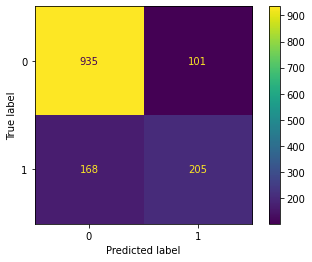


Logistic Regression Confusion Matrix
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1036
           1       0.67      0.55      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409


Accuracy: 0.809


In [25]:
#Produce and save the model, then load and apply the model.
gbm = GradientBoostingClassifier()
gbm.fit(x_trainPoly, y_trainPoly)
gbm_predictions = gbm.predict(x_testPoly)

gbm_matrix = metrics.confusion_matrix(y_testPoly,gbm_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",gbm_matrix)

plot_confusion_matrix(gbm, x_testPoly, y_testPoly)  
plt.show()

class_report_gbm = classification_report(y_testPoly, gbm_predictions)
print("\nLogistic Regression Confusion Matrix\n",class_report_gbm)

print("\nAccuracy:",round(metrics.accuracy_score(y_testPoly,gbm_predictions),3))

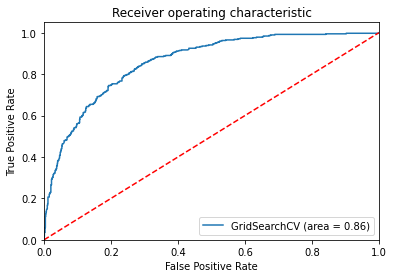

In [30]:
roc_curve(gbm)

### Boost Classification Model 


Gradient Boosting Classifier Confusion Matrix
 [[933 103]
 [169 204]]


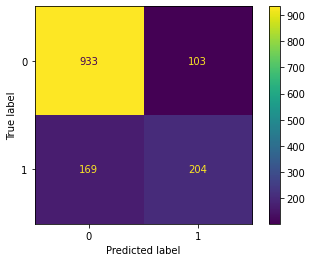


Logistic Regression Confusion Matrix
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1036
           1       0.66      0.55      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409


Accuracy: 0.807


In [32]:
#Produce and save the model, then load and apply the model.
ada = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
ada.fit(x_trainPoly, y_trainPoly)
ada_predictions = ada.predict(x_testPoly)

ada_matrix = metrics.confusion_matrix(y_testPoly,ada_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",ada_matrix)

plot_confusion_matrix(ada, x_testPoly, y_testPoly)  
plt.show()

class_report_ada = classification_report(y_testPoly, ada_predictions)
print("\nLogistic Regression Confusion Matrix\n",class_report_ada)

print("\nAccuracy:",round(metrics.accuracy_score(y_testPoly,ada_predictions),3))

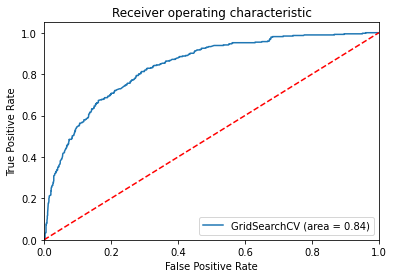

In [33]:
roc_curve(ada)

### Random Forest 


Gradient Boosting Classifier Confusion Matrix
 [[935 101]
 [172 201]]


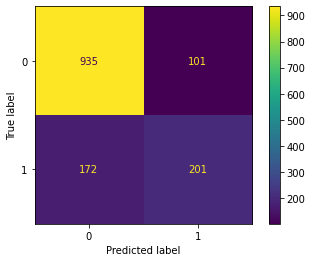


Logistic Regression Confusion Matrix
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.67      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409


Accuracy: 0.806


In [34]:
#Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(n_estimators=30, max_depth=9)
rfc.fit(x_trainPoly, y_trainPoly)
rfc_predictions = rfc.predict(x_testPoly)

rfc_matrix = metrics.confusion_matrix(y_testPoly,rfc_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",rfc_matrix)

plot_confusion_matrix(rfc, x_testPoly, y_testPoly)  
plt.show()

class_report_rfc = classification_report(y_testPoly, rfc_predictions)
print("\nLogistic Regression Confusion Matrix\n",class_report_rfc)

print("\nAccuracy:",round(metrics.accuracy_score(y_testPoly,rfc_predictions),3))

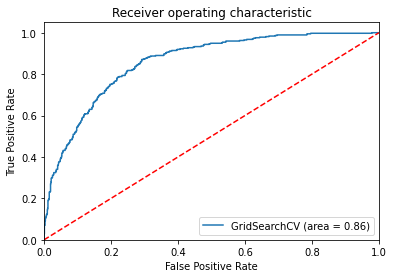

In [35]:
roc_curve(rfc)